# Домашно 1


### В това домашно задачата ви е да класифицирате всяка картинка от тестовото множество във 53-те различни класа. Накрая покажете какво е accuracy-то на вашия модел върху това тестово множество. (Accuracy = Correct/Total).

In [1]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

### За да можете да заредите Kaggle dataset, трябва да се логнете в Kaggle и да изтеглите API Token от Settings -> Create New Token. Това ще свали kaggle.json файл, който трябва да качите в следващата клетка.

In [2]:
df = pd.read_csv("./DATA/cards-image-datasetclassification/cards.csv")
df.head()

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


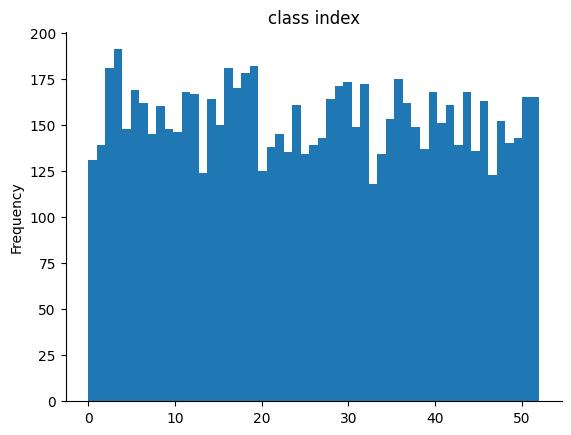

In [3]:
# @title class index

from matplotlib import pyplot as plt
df['class index'].plot(kind='hist', bins=53, title='class index')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [4]:
df[df["data set"] == "train"].shape, df[df["data set"] == "valid"].shape, df[df["data set"] == "test"].shape,

((7625, 5), (265, 5), (265, 5))

In [5]:
df["labels"].unique()

array(['ace of clubs', 'ace of diamonds', 'ace of hearts',
       'ace of spades', 'eight of clubs', 'eight of diamonds',
       'eight of hearts', 'eight of spades', 'five of clubs',
       'five of diamonds', 'five of hearts', 'five of spades',
       'four of clubs', 'four of diamonds', 'four of hearts',
       'four of spades', 'jack of clubs', 'jack of diamonds',
       'jack of hearts', 'jack of spades', 'joker', 'king of clubs',
       'king of diamonds', 'king of hearts', 'king of spades',
       'nine of clubs', 'nine of diamonds', 'nine of hearts',
       'nine of spades', 'queen of clubs', 'queen of diamonds',
       'queen of hearts', 'queen of spades', 'seven of clubs',
       'seven of diamonds', 'seven of hearts', 'seven of spades',
       'six of clubs', 'six of diamonds', 'six of hearts',
       'six of spades', 'ten of clubs', 'ten of diamonds',
       'ten of hearts', 'ten of spades', 'three of clubs',
       'three of diamonds', 'three of hearts', 'three of spades',

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [7]:
train_dataset = ImageFolder('./DATA/cards-image-datasetclassification/train', transform=train_transform)
test_dataset = ImageFolder('./DATA/cards-image-datasetclassification/test', transform=val_test_transform)
val_dataset = ImageFolder('./DATA/cards-image-datasetclassification/valid', transform=val_test_transform)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
class CardCNN(nn.Module):
    def __init__(self, num_classes=53):
        super(CardCNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.network(x)


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CardCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(15):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1, Loss: 3.0330
Epoch 2, Loss: 2.0335
Epoch 3, Loss: 1.6312
Epoch 4, Loss: 1.2466
Epoch 5, Loss: 0.9754
Epoch 6, Loss: 0.7551
Epoch 7, Loss: 0.6030
Epoch 8, Loss: 0.4646
Epoch 9, Loss: 0.3365
Epoch 10, Loss: 0.2932
Epoch 11, Loss: 0.2784
Epoch 12, Loss: 0.2471
Epoch 13, Loss: 0.2054
Epoch 14, Loss: 0.1849
Epoch 15, Loss: 0.1616


In [11]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 86.04%


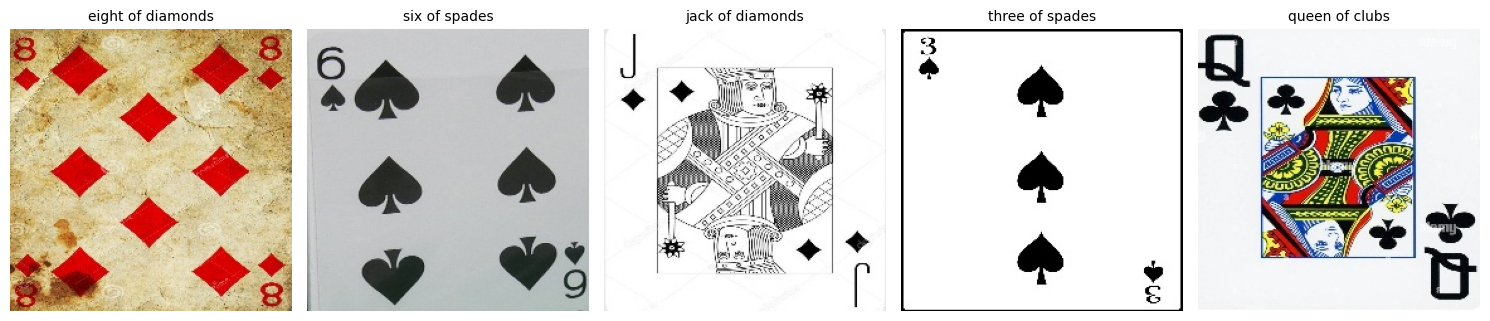

In [14]:
valid_dir = "./DATA/cards-image-datasetclassification/valid"

idx_to_class = {v: k for k, v in val_dataset.class_to_idx.items()}

all_image_paths = []
for root, dirs, files in os.walk(valid_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_image_paths.append(os.path.join(root, file))

random_image_paths = random.sample(all_image_paths, 5)

model.eval()

plt.figure(figsize=(15, 6))

for idx, img_path in enumerate(random_image_paths):
    image_raw = Image.open(img_path).convert('RGB')
    input_tensor = val_test_transform(image_raw).unsqueeze(0) 

    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)
        predicted_label = idx_to_class[pred.item()]

    plt.subplot(1, 5, idx + 1)
    plt.imshow(image_raw)
    plt.title(predicted_label, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()
